# Object Detection

In [1]:
!git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


# Imports

In [84]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pprint as pp

from functools import partial
from collections import defaultdict, namedtuple
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [65]:
# Alias for compact printing.
cprint = partial(pp.pprint, compact=True)

# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append(os.path.abspath('models/research'))
sys.path.append(os.path.abspath('models/research/object_detection'))

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

In [9]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model 
# that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('models/research/object_detection/data', 
                              'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map

In [142]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True
)
category_index = label_map_util.create_category_index(categories)
category_id = {category['name']: category['id'] for category in categories}

In [101]:
categories[:4]

[{'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'bicycle'},
 {'id': 3, 'name': 'car'},
 {'id': 4, 'name': 'motorcycle'}]

In [107]:
categories_set = set(_['name'] for _ in categories)
cprint(categories_set)

{'airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove',
 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl',
 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair',
 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant',
 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse',
 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle',
 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant',
 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink',
 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign',
 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster',
 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella',
 'vase', 'wine glass', 'zebra'}


## Helper code

In [11]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [78]:
# PASCAL VOC consts.
PATH_TO_VOC = 'data/VOCdevkit/VOC2012'
PATH_TO_IMAGES = os.path.join(PATH_TO_VOC, 'JPEGImages')
PATH_TO_ANNS = os.path.join(PATH_TO_VOC, 'Annotations')
PATH_TO_IMAGE_SETS = os.path.join(PATH_TO_VOC, 'ImageSets/Main')

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [79]:
all_files = !ls {PATH_TO_IMAGE_SETS}
image_sets = list(set(_[:-4].split('_')[0] for _ in all_files))
cprint(image_sets)

['car', 'cat', 'chair', 'bottle', 'motorbike', 'bus', 'person', 'sofa', 'sheep',
 'boat', 'tvmonitor', 'val', 'cow', 'train', 'bicycle', 'diningtable',
 'pottedplant', 'bird', 'trainval', 'horse', 'aeroplane', 'dog']


In [116]:
image_names = [_[:-1] for _ in open(os.path.join(PATH_TO_IMAGE_SETS, 'val.txt'))]
images = [os.path.join(PATH_TO_IMAGES, f'{_}.jpg') for _ in image_names]
len(images)

5823

In [81]:
import xml.etree.ElementTree as ET
ann_paths = [os.path.join(PATH_TO_ANNS, f'{_}.xml') for _ in image_names]
anns = [ET.parse(_).getroot() for _ in ann_paths]

In [119]:
BB = namedtuple('BB', ['xmin', 'xmax', 'ymin', 'ymax'])
Obj = namedtuple('Obj', ['bb', 'lbl'])


def parse_objs(node):
    def get_bb(node):
        args = {child.tag: child.text for child in node}
        return BB(float(args['xmin']), float(args['xmax']), 
                  float(args['ymin']), float(args['ymax']))

    
    def get_obj(node):
        args = {child.tag: child for child in node}
        return Obj(get_bb(args['bndbox']), args['name'].text)

    
    return [get_obj(child) for child in node if child.tag == "object"]


cprint([parse_objs(_) for _ in anns[:4]])

[[Obj(bb=BB(xmin=1.0, xmax=428.0, ymin=230.0, ymax=293.0), lbl='boat')],
 [Obj(bb=BB(xmin=9.0, xmax=500.0, ymin=32.0, ymax=375.0), lbl='car')],
 [Obj(bb=BB(xmin=445.0, xmax=500.0, ymin=254.0, ymax=335.0), lbl='car')],
 [Obj(bb=BB(xmin=292.0, xmax=328.0, ymin=197.0, ymax=228.0), lbl='car')]]


In [120]:
def testable(ann):
    objs = parse_objs(ann)
    return len(objs) and len(objs) == len(np.unique(_.lbl for _ in objs)) \
        and all(_.lbl in categories_set for _ in objs)


images, anns = zip(*((i, a) for i, a in zip(images, anns) if testable(a)))
images, anns = list(images), list(anns)
len(images), len(anns)

(2037, 2037)

In [129]:
Res = namedtuple("Res", ['boxes', 'scores', 'classes'])


def detect_objects(images, anns, visualize=False):
    ress = []
    with detection_graph.as_default(), tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for i, (image_path, ann) in enumerate(zip(images, anns)):
            # Preparation.
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Actual detection.
            boxes, scores, classes, num = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded}
            )
            ress.append(Res(boxes.squeeze(), scores.squeeze(), classes.squeeze()))
            
            # Visualization of the results of a detection.
            if visualize:
                vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  use_normalized_coordinates=True,
                  line_thickness=8)
                plt.figure(figsize=IMAGE_SIZE)
                plt.imshow(image_np)
            
            if (i % 50 == 0) or (i == len(images) - 1):
                print(f"At {i}th iteration")
    
    return ress

At 0th iteration


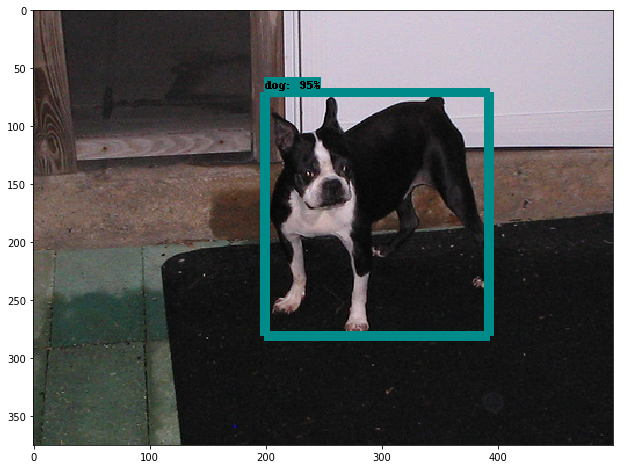

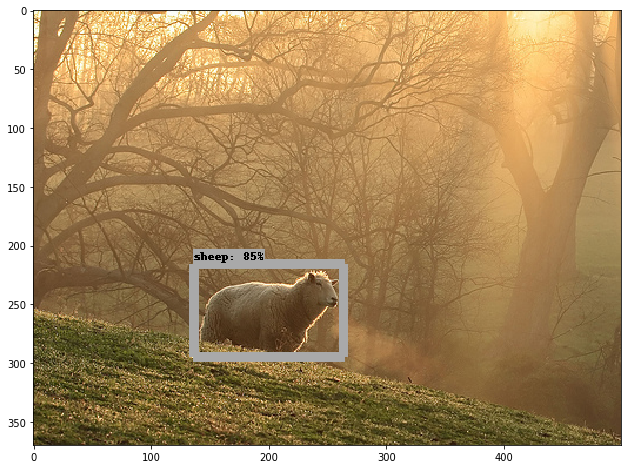

In [128]:
detect_objects(images[10:12], anns[10:12], visualize=True)

# Test

In [130]:
ress = detect_objects(images[:500], anns[:500])

At 0th iteration
At 50th iteration
At 100th iteration
At 150th iteration
At 200th iteration
At 250th iteration
At 300th iteration
At 350th iteration
At 400th iteration
At 450th iteration


In [205]:
def square(bb):
    if (bb.xmax < bb.xmin) or (bb.ymax < bb.ymin):
        return 0.
    return (bb.xmax - bb.xmin) * (bb.ymax - bb.ymin)


def intersection(bb1, bb2):
    return square(BB(max(bb1.xmin, bb2.xmin), min(bb1.xmax, bb2.xmax), 
                     max(bb1.ymin, bb2.ymin), min(bb1.ymax, bb2.ymax)))


def iou(bb1, bb2):
    return intersection(bb1, bb2) / (square(bb1) + square(bb2) - intersection(bb1, bb2))


def parse_bb(args):
    return BB(375 * float(args[0]), 500 * float(args[2]), 
              375 * float(args[1]), 500 * float(args[3]))


def mean_iou(ann, res):
    objs = parse_objs(ann)
    
    def max_iou(obj):
        inds = [res.classes == category_id[obj.lbl]]
        if np.sum(inds):  # At least one `True`.
            boxes = [parse_bb(box) for box in res.boxes[inds]]
            return np.max([iou(box, obj.bb) for box in boxes])
        else:
            return 0
    
    return np.mean([max_iou(obj) for obj in objs])

In [206]:
total_iou = np.mean([mean_iou(ann, res) for ann, res in zip(anns, ress)])

In [195]:
def acc(ann, res):
    objs = parse_objs(ann)
   
    def good_acc(obj, treshold=0.5):
        inds = [res.classes == category_id[obj.lbl]]
        if np.sum(inds):  # At least one `True`.
            max_score = np.max(res.scores[inds])
            return max_score if max_score >= treshold else 0
        else:
            return 0
    
    return np.mean([good_acc(obj) for obj in objs])

In [198]:
total_acc = np.mean([acc(ann, res) for ann, res in zip(anns, ress)])

In [212]:
f"mean IOU: {total_iou}"

'mean IOU: 0.5111492295611365'

In [211]:
f"mean accuracy: {total_acc}"

'mean accuracy: 0.7156916173696518'